In [1]:
%%capture
%pip install hf_xet transformers sklearn

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import T5TokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

import numpy as np


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datasetpath = "./cnn_dailymail/"
outputpath = "./data/"
trainpath = datasetpath + 'train.csv'
testpath = datasetpath + 'test.csv'
valpath = datasetpath + 'validation.csv'

train = pd.read_csv(trainpath)
test = pd.read_csv(testpath)
val = pd.read_csv(valpath)

df = pd.concat([train, test, val], ignore_index=True)

In [4]:
df.shape

(311971, 3)

### Remove random 88%

In [5]:
df = df.sample(frac=0.12)
df.shape


(37437, 3)

### Cosine Similarity analysis

In [6]:
vectorizer  = TfidfVectorizer(stop_words="english")

def cosine_similarity_analysis(df):
    tfidf_matrix = vectorizer.fit_transform(df['article'].tolist() + df['highlights'].tolist())
    article_vectors = tfidf_matrix[:len(df)]
    highlights_vectors = tfidf_matrix[len(df):]

    cosine_sim = [cosine_similarity(article_vectors[i], highlights_vectors[i])[0][0] for i in range(len(df))]

    result_df = pd.DataFrame({
        'id': df['id'],
        'cosine_similarity': cosine_sim
    })

    return result_df

### Trim data with cosine similarity below 0.3.

In [7]:
cosine_df = cosine_similarity_analysis(df)

In [8]:
df = df[cosine_df['cosine_similarity'] >= 0.3]
df.shape

(34511, 3)

### Token-frequency-based-filtering-and-vocabulary-aware stratified sampling

In [9]:
def stratified_split(df, tokenized_df, min_freq=3, qcut=5):

    # Flatten all tokens from titles and abstracts
    all_tokens = (
        tokenized_df['tokenized_article'].explode().tolist()
        + tokenized_df['tokenized_highlights'].explode().tolist()
    )

    token_freq = Counter(all_tokens)

    valid_tokens = {tok for tok, freq in token_freq.items() if freq >= min_freq}

    # Calculate vocabulary for each abstract
    tokenized_df["vocab"] = tokenized_df.apply(
            lambda row: set(
                tok for tok in row["tokenized_highlights"] + row["tokenized_article"]
                if tok in valid_tokens
            ),
            axis=1,
        )

    # Create a global vocabulary
    global_vocab = set().union(*tokenized_df["vocab"])

    # Calculate overlap with global vocabulary
    tokenized_df["overlap"] = tokenized_df["vocab"].apply(
        lambda x: len(x & global_vocab) / len(global_vocab) if global_vocab else 0
    )

    # Bin overlap into categories for stratification
    tokenized_df["overlap_bin"] = pd.qcut(tokenized_df["overlap"], q=qcut, labels=False)

    # Perform stratified splitting
    train_idx, temp_idx = train_test_split(
        tokenized_df.index,
        test_size=0.2,
        stratify=tokenized_df["overlap_bin"],
        random_state=42,
    )
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=tokenized_df.loc[temp_idx, "overlap_bin"],
        random_state=42,
    )

    # Extract dataframes
    train_df = tokenized_df.loc[train_idx]
    val_df = tokenized_df.loc[val_idx]
    test_df = tokenized_df.loc[test_idx]

    # Count words in val and test that are not in train
    train_vocab = set().union(*train_df["vocab"])
    val_vocab = set().union(*val_df["vocab"])
    test_vocab = set().union(*test_df["vocab"])

    val_not_train = len(val_vocab - train_vocab)
    test_not_train = len(test_vocab - train_vocab)

    return {
        "train_df": df.loc[train_idx],
        "val_df": df.loc[val_idx],
        "test_df": df.loc[test_idx],
        "val-train": val_not_train,
        "test-train": test_not_train,
    }

In [10]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

tokenized_df = pd.DataFrame()
tokenized_df['tokenized_article'] = df['article'].apply(lambda x: word_tokenize(x))
tokenized_df['tokenized_highlights'] = df['article'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


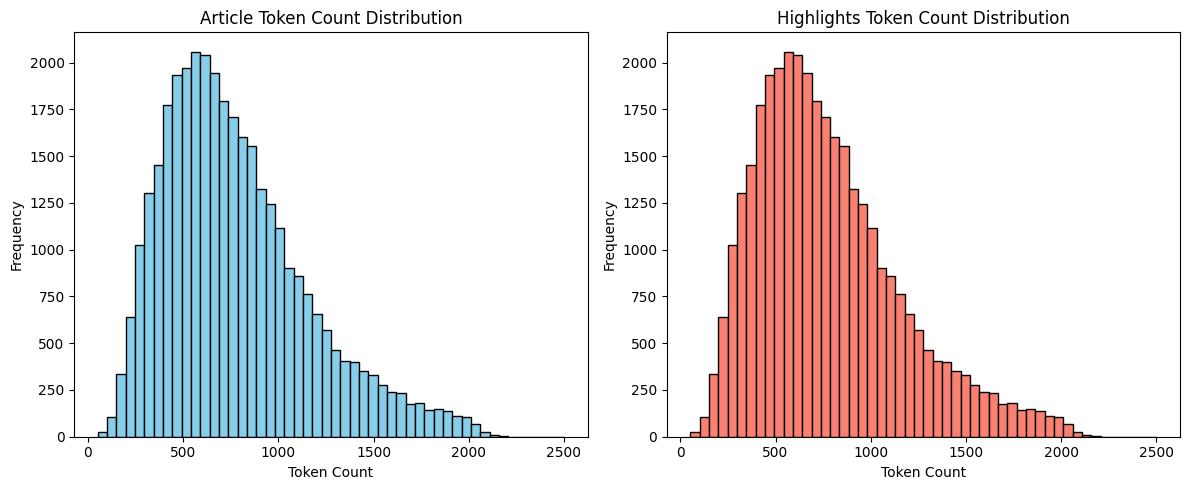

In [11]:
import matplotlib.pyplot as plt

tokenized_df['article_token_count'] = tokenized_df['tokenized_article'].apply(len)
tokenized_df['highlights_token_count'] = tokenized_df['tokenized_highlights'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(tokenized_df['article_token_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Article Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(tokenized_df['highlights_token_count'], bins=50, color='salmon', edgecolor='black')
plt.title('Highlights Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [12]:
tokenized_df = tokenized_df[(tokenized_df['article_token_count'] >= 128) & (tokenized_df['article_token_count'] <= 1024) & (tokenized_df['highlights_token_count'] >= 128) & (tokenized_df['highlights_token_count'] <= 1024)]
tokenized_df.shape


(26742, 4)

### Stratified sampling

In [13]:
cache = stratified_split(df, tokenized_df)
print(f"Number of words that are in VALIDATION set but not in TRAIN set: {cache['val-train']}")
print(f"Number of words that are in TEST set but not in TRAIN set: {cache['test-train']}")

Number of words that are in VALIDATION set but not in TRAIN set: 3396
Number of words that are in TEST set but not in TRAIN set: 3404


In [14]:
cache['train_df'].to_csv(outputpath + "cleaned_train.csv", index=False)
cache['val_df'].to_csv(outputpath + "cleaned_validation.csv", index=False)
cache['test_df'].to_csv(outputpath + "cleaned_test.csv", index=False)

print("Size of train, val and test datasets:")
print(f"Train: {cache['train_df'].shape}")
print(f"Validation: {cache['val_df'].shape}")
print(f"Test: {cache['test_df'].shape}")

Size of train, val and test datasets:
Train: (21393, 3)
Validation: (2674, 3)
Test: (2675, 3)
